# Cloud inpainting



In [1]:
try: # install all dependencies in colab 
    import google.colab
    !sudo apt-get update -y
    !sudo apt-get install -y libnvidia-gl-555 vulkan-tools glslang-tools vulkan-validationlayers-dev
    !pip install pyav==13.1.0
    !pip install git+https://github.com/rendervous/cloudy_project.git
except:
    print("Executing locally")

Executing locally


Let's import required modules and define tools methods. Check previous examples for details.

/home/leonard/rendervous.project/rdv_env/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


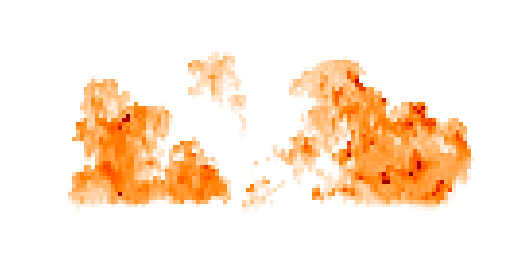

stdin


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


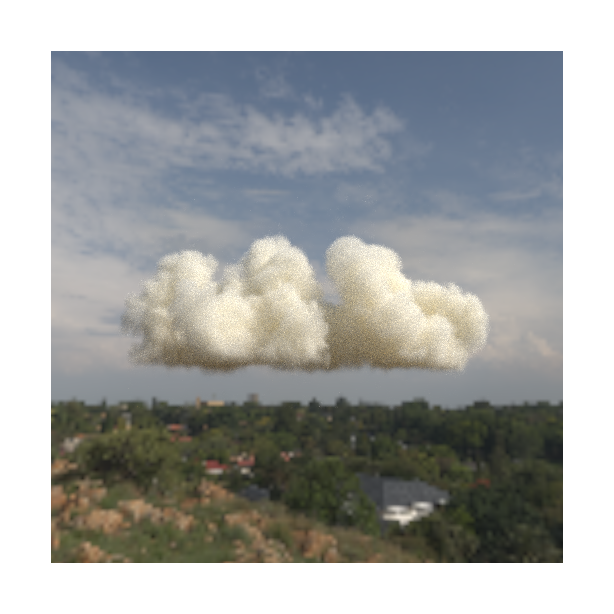

In [2]:
import torch
import cloudy
import matplotlib.pyplot as plt
import vulky.datasets as datasets


pipeline = cloudy.create_pipeline('./test')
# pipeline.download_pretrained()

# define the camera pose
camera_poses = cloudy.camera_poses((3.0, -0.5, -0.4))
environment = datasets.Images.environment_example.to(pipeline.get_device())

def render_as_cloud(g):
    with torch.no_grad():
        im = cloudy.scattered(g * 300,
                              camera_poses=camera_poses,
                              scattering_albedo=(0.99, 0.98, 0.94),
                              environment=environment,
                              phase_g=0.0,
                              majorant=g.max()*300,
                              # kwargs
                              width=512,
                              height=512,
                              jittered=True,
                              samples=128
                              )
        plt.figure(figsize=(1, 1), dpi=512)
        plt.imshow(im[0].cpu() ** (1.0/2.2))
        plt.gca().invert_yaxis()
        plt.gca().axis('off')
        plt.tight_layout(pad=0.0)
        plt.show()


def show_slice(g: torch.Tensor):
    plt.imshow(g[:, :, g.shape[2]//2, 0].cpu().T, cmap='gist_heat_r', vmin=0.0, vmax=0.6)
    plt.gca().invert_yaxis()
    plt.gca().axis('off')
    plt.show()
    
ref_latent = pipeline.get_test_latent(8)  

with torch.no_grad():
    ref_grid = pipeline.from_latent_to_grid(ref_latent).clamp_min(0.0)

show_slice(ref_grid)
render_as_cloud(ref_grid)

For inpainting tasks we assume there is a mask $\mathcal{M}$ for the values we want to preserve. The masked grid can be computed as: 

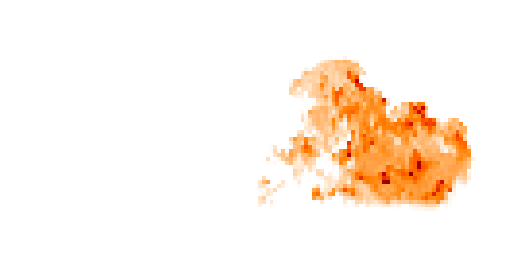

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


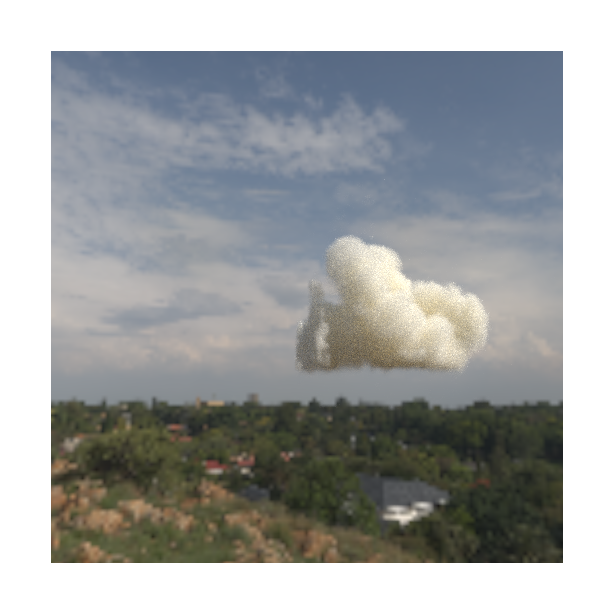

In [3]:
mask = torch.ones_like(ref_grid)
mask[:mask.shape[0]//2] = 0.0  # clear a half of the volume

with torch.no_grad():
    masked_grid = ref_grid * mask
    
show_slice(masked_grid)

render_as_cloud(masked_grid)

The criteria for the posterior sampling will be:

$$
\mathcal{A}(x) = \mathcal{M} \otimes \mathcal{D}(x)
$$

In [4]:
def criteria(latent):
    g = pipeline.from_latent_to_grid(latent, resolution=128).clamp_min(0.0)
    yhat = mask * g
    return ((masked_grid - yhat) ** 2).sum()

Generate a latent given the criteria.

In [5]:
latent = pipeline.generate_latent(
    samples=400,
    scheduler_gamma=.4,
    criteria=criteria,
    criteria_scale=0.5
)

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


Posterior sampling DPS_DDIM: 100%|██████████| 400/400 [01:31<00:00,  4.39it/s]


Let's visualize the generated cloud.

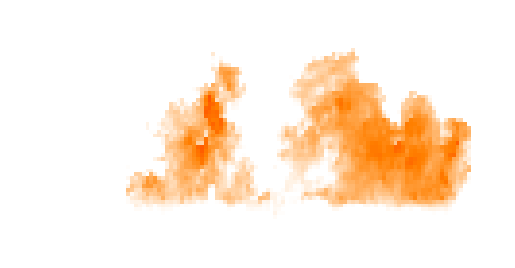

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


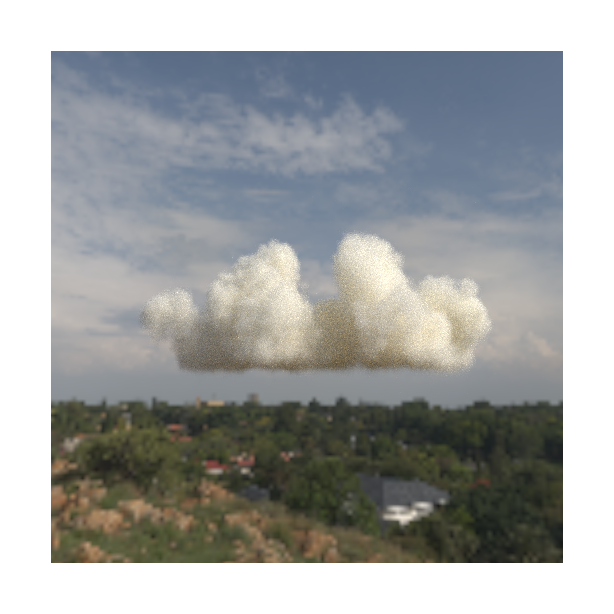

In [6]:
with torch.no_grad():
    inf_grid = pipeline.from_latent_to_grid(latent).clamp_min(0.0)

show_slice(inf_grid)

render_as_cloud(inf_grid)